# **Week 3: CNN Cancer Detection Kaggle Mini-Project**
***
## **Overview**

In this competition, you must create an algorithm to identify metastatic cancer in small image patches taken from larger digital pathology scans. The data for this competition is a slightly modified version of the PatchCamelyon (PCam) benchmark dataset (the original PCam dataset contains duplicate images due to its probabilistic sampling, however, the version presented on Kaggle does not contain duplicates).

(Please refer to https://www.kaggle.com/c/histopathologic-cancer-detection/overview for additional information about this dataset.)


***
## **Step 0 Import Libraries and Load Data**

In [2]:
import os
import random
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import tensorflow as tf

os.environ['PYTHONHASHSEED'] = '123'
random.seed(123)
np.random.seed(123)
tf.random.set_seed(123)

In [4]:
train_labels = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')
train_path = '/kaggle/input/histopathologic-cancer-detection/train'
test_path = '/kaggle/input/histopathologic-cancer-detection/test'

***
## **Step 1 Brief Description**

#### **1.1 Problem**
- This problem involves a **binary classification** task on histopathology images to identify metastatic cancer.

- The `train_labels.csv` file serves as the ground truth for the images in the `train` folder, while the goal is to predict labels **(whether cancer is present or not)** for the images contained in the `test` folder.

#### **1.2 Data**
- The **`train_labels.csv`** file has **220,025** rows and **2** columns, where `id` is the unique identifier for each image, and `label` indicates the presence (1) or absence (0) of metastatic cancer.

- There are **220,025** training images and **57,458** testing images.

- Each image is **96×96** pixels with **3** color channels.

In [3]:
# Dimensions of the 'train_labels' DataFrame
train_labels.shape

(220025, 2)

In [4]:
# Have a look at the format
train_labels.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [5]:
# Number of training and testing images
print(len([f for f in os.listdir(train_path) if f.endswith('.tif')]))
print(len(os.listdir(test_path)))

220025
57458


In [6]:
import cv2

In [7]:
# Image dimensions in the format (height, width, channels)
tif_files = [f for f in os.listdir(train_path) if f.endswith('.tif')]
img = cv2.imread(os.path.join(train_path, tif_files[0]))

print(f"Image shape: {img.shape}")

Image shape: (96, 96, 3)


***
## **Step 2 EDA**

#### **2.1 Check for Missing Values**
- There seems to be **no null values** or **NA** across the columns.

In [8]:
# Check for missing values
print(train_labels.isnull().sum())
print("-" * 15)
print(train_labels.isna().sum())
print("-" * 15)

id       0
label    0
dtype: int64
---------------
id       0
label    0
dtype: int64
---------------


***
#### **2.2 Visualizations**

- **Dataset Balance**:

  - **No Cancer**: 130,908 cases (59.5%)
  - **Cancer**: 89,117 cases (40.5%)
  - The dataset is **moderately imbalanced**, with a higher proportion of "No Cancer" cases compared to "Cancer."

In [5]:
import matplotlib.pyplot as plt

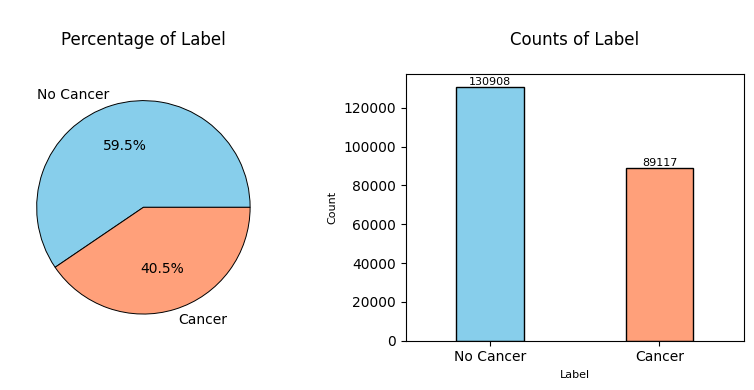

In [10]:
# Cancer distribution
# Count the number of 0s and 1s in the 'label' column
counts = train_labels['label'].value_counts()

# Create a figure with two subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# Create a mapping for the labels: 0 => "No Cancer", 1 => "Cancer"
label_mapping = {0: 'No Cancer', 1: 'Cancer'}
mapped_labels = [label_mapping[label] for label in counts.index]

# 1. Pie chart
axes[0].pie(
    counts.values,
    labels=mapped_labels,
    autopct='%1.1f%%',
    colors=['skyblue', 'lightsalmon'],
    wedgeprops={'edgecolor': 'black', 'linewidth': 0.7}
)
axes[0].set_title('\nPercentage of Label\n', fontsize=12)

# 2. Bar chart
bars = axes[1].bar(mapped_labels, counts.values, color=['skyblue', 'lightsalmon'], edgecolor='black', width=0.4)
axes[1].set_xlabel('Label', fontsize=8)
axes[1].set_ylabel('Count', fontsize=8)
axes[1].set_title('\nCounts of Label\n', fontsize=12)
axes[1].set_xlim(-0.5, 1.5)

# Annotate each bar with its count value
for bar in bars:
    height = bar.get_height()
    axes[1].text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f'{int(height)}',
        ha='center',
        va='bottom',
        fontsize=8
    )

plt.tight_layout()
plt.show()

***
- **Analysis of Images**:
  
  - **Labels (0 vs. 1)**:
    - **Label 0 (No Cancer)**: More white space and loosely arranged cells.
    - **Label 1 (Cancer)**: Dense, irregularly shaped cell clusters.<br><br>
      
  - **Color Differences**:

    - Purple, violet, pink, and red colors.
    - Variations may arise from staining techniques or imaging equipment.

In [6]:
import matplotlib.image as mpimg

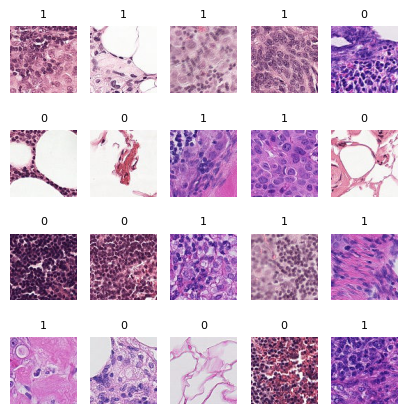

In [7]:
# Sample 20 random image
sampled_ids = random.sample(train_labels['id'].tolist(), 20)

# Map IDs to labels
id_to_label = train_labels.set_index('id')['label']

# Plot sample images
fig, axes = plt.subplots(4, 5, figsize=(5, 5))
fig.subplots_adjust(hspace=0.4, wspace=0.2)

for i, ax in enumerate(axes.flat):
    curr_id = sampled_ids[i]
    img_path = os.path.join(train_path, f'{curr_id}.tif')
    label = id_to_label[curr_id]
    img = mpimg.imread(img_path)
    ax.imshow(img)
    ax.set_title(f'{label}', fontsize=8)
    ax.axis('off')

plt.show()

***
#### **2.3 Data Preprocessing**
- **Sampling**:
  - Randomly samples 80,000 rows from both "No Cancer" (`label == 0`) and "Cancer" (`label == 1`) to balance the dataset, ensuring equal representation of both classes.<br><br>

- **Shuffling**:
  - Combines the two sampled datasets and shuffles them to mix the "No Cancer" and "Cancer" examples randomly for training purposes.<br><br>

- **Splitting**:
  - Prepares the balanced and shuffled dataset for training by splitting it into training and validation sets to enhance model development and evaluation.<br><br>

- **Data Generators**:
  - Dividing by 255 **normalizes** pixel values to [0, 1] for better model training.

  - In addition to the original color generators, **grayscale** generators were created by setting `color_mode="grayscale"` to evaluate the impact of grayscale conversion on model performance.

In [13]:
from sklearn.utils import shuffle

In [14]:
# Sampling
df_0=train_labels[train_labels['label']==0].sample(80000, random_state=123)
df_1=train_labels[train_labels['label']==1].sample(80000, random_state=123)

# Shuffling
df = shuffle(pd.concat([df_0, df_1], axis=0).reset_index(drop=True))

df['label'].value_counts()

label
0    80000
1    80000
Name: count, dtype: int64

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
# Splitting data into training and validation sets
y = df['label']

df_train, df_val = train_test_split(df, test_size=0.2, random_state=123, stratify=y)

print(df_train.shape)
print(df_val.shape)

(128000, 2)
(32000, 2)


In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [18]:
# Append the '.tif' extension to the id column so that it matches the image file names
df_train['id'] = df_train['id'] + '.tif'
df_val['id'] = df_val['id'] + '.tif'

# Convert the labels to string type
df_train['label'] = df_train['label'].astype(str)
df_val['label'] = df_val['label'].astype(str)

print(df_train['id'].head())

76831     0562bf0e891552960b47e8e10a17b5b175bc3373.tif
13993     65c1e2d92193d9fc8254afb7b1bde0bb27ca345a.tif
101636    3e3de9f966f0cbda3ad54766fbca9e4290201a8b.tif
47366     2e516fc5852d63167e7bcbe74116bf69d2cec901.tif
48938     07582c073da909fdff9548d1e944ec3c5aba01c4.tif
Name: id, dtype: object


In [19]:
# Create an ImageDataGenerator
datagen = ImageDataGenerator(rescale=1/255)

# Create the training data generator (color images)
train_generator = datagen.flow_from_dataframe(
    dataframe=df_train,
    directory=train_path,
    x_col="id",
    y_col="label",
    batch_size=64,
    seed=123,
    class_mode="binary",
    target_size=(96, 96)
)

# Create the validation data generator (color images)
valid_generator = datagen.flow_from_dataframe(
    dataframe=df_val,
    directory=train_path,
    x_col="id",
    y_col="label",
    batch_size=64,
    seed=123,
    class_mode="binary",
    target_size=(96, 96)
)

Found 128000 validated image filenames belonging to 2 classes.
Found 32000 validated image filenames belonging to 2 classes.


In [20]:
# Create an ImageDataGenerator
datagen = ImageDataGenerator(rescale=1/255)

# Create the training data generator (grayscale images)
train_generator2 = datagen.flow_from_dataframe(
    dataframe=df_train,
    directory=train_path,
    x_col="id",
    y_col="label",
    batch_size=64,
    seed=123,
    class_mode="binary",
    target_size=(96, 96),
    color_mode="grayscale"   # Convert images to grayscale
)

# Create the validation data generator (grayscale images)
valid_generator2 = datagen.flow_from_dataframe(
    dataframe=df_val,
    directory=train_path,
    x_col="id",
    y_col="label",
    batch_size=64,
    seed=123,
    class_mode="binary",
    target_size=(96, 96),
    color_mode="grayscale"   # Convert images to grayscale
)

Found 128000 validated image filenames belonging to 2 classes.
Found 32000 validated image filenames belonging to 2 classes.


***
## **Step 3 Model Architecture**

The first and second CNN models were developed for binary classification, focusing on architectural design and hyperparameter tuning. Both use **convolutional layers** with **ReLU** activation for feature extraction, **max-pooling** for dimensionality reduction, **dense layers** for decision-making, and **dropout** for overfitting prevention. The **Adam optimizer** was chosen for its efficiency in training deep models, using the default learning rate.

The **second model** was explicitly designed for **grayscale images** to explore how removing color information might impact the classification task. This approach was motivated by the hypothesis that grayscale images might focus the model's attention on **structural patterns** rather than **color** features. The goal was to compare the performance of the two models and analyze the impact of color information on classification accuracy.

![Model Structure](model_structure.png)

#### **3.1 First Model**
- **Input**: RGB images **(96x96x3)**, utilizing both spatial and color information.

- **Filter Counts**: Higher, starting at **32** and scaling up to **128**, to handle the complexity of RGB data.

- **Dropout**: `0.5` to address the higher overfitting risk due to data complexity.

#### **3.2 Second Model**
- **Input**: Grayscale images **(96x96x1)**, focusing on structural and intensity-based patterns.

- **Filter Counts**: Lower, starting at **16** and scaling up to **64**, reflecting the simpler nature of grayscale data.

- **Padding**: `same`, to preserve spatial dimensions after convolution.

- **Dropout**: `0.3`, suitable for the reduced data complexity.

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [22]:
# Create the first CNN model
model = Sequential([
    # Input layer
    Input(shape=(96, 96, 3)),

    # First Convolutional layer
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    # Second Convolutional layer
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    # Third Convolutional layer
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    # Flatten the output and add Dense layers
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),

    # Output layer for binary classification
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(
    optimizer=Adam(),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 94, 94, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 47, 47, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 20, 20, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 10, 10, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,638,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,731,905 (6.61 MB)

 Trainable params: 1,731,905 (6.61 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
# Create the second CNN model (for grayscale images)
model2 = Sequential([
    # Input layer
    Input(shape=(96, 96, 1)),     # Input: grayscale image, original image shape = (96, 96, 3)

    # First convolution layer
    Conv2D(16, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),

    # Second convolution layer
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),

    # Third convolution layer
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),

    # Flatten and Dense layers
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.3),

    # Output layer for binary classification
    Dense(1, activation='sigmoid')
])

model2.compile(
    optimizer=Adam(),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 96, 96, 16)          │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 48, 48, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 48, 48, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 24, 24, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │         589,888 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 613,249 (2.34 MB)

 Trainable params: 613,249 (2.34 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
import time
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

Epoch 1/20
1999/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 564ms/step - accuracy: 0.7613 - loss: 0.4983
Epoch 1: val_loss improved from inf to 0.36480, saving model to model_kaggle.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1437s 714ms/step - accuracy: 0.7614 - loss: 0.4983 - val_accuracy: 0.8394 - val_loss: 0.3648
Epoch 2/20
1999/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.8386 - loss: 0.3755
Epoch 2: val_loss improved from 0.36480 to 0.33424, saving model to model_kaggle.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 329s 164ms/step - accuracy: 0.8386 - loss: 0.3755 - val_accuracy: 0.8508 - val_loss: 0.3342
Epoch 3/20
1999/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.8652 - loss: 0.3225
Epoch 3: val_loss improved from 0.33424 to 0.28731, saving model to model_kaggle.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 202s 101ms/step - accuracy: 0.8652 - loss: 0.3224 - val_accuracy: 0.8812 - val_loss: 0.2873
Epoch 4/20
1999/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.8826 - loss: 0.2810
Epoch 4: val_lo

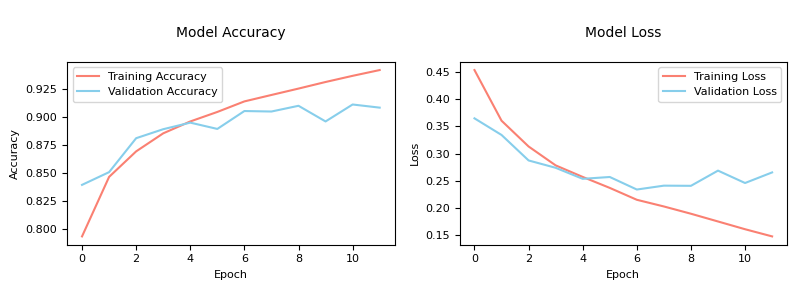

In [25]:
# Create ModelCheckpoint callback
checkpoint = ModelCheckpoint(
    filepath='model_kaggle.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Create EarlyStopping callback
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# Start timer
start_time = time.time()

# Train the model
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=20,
    callbacks=[checkpoint, early_stop]
)

# End timer
end_time = time.time()
print("-" * 120)

# Calculate total time
total_time = end_time - start_time
hours, remainder = divmod(total_time, 3600)
minutes, seconds = divmod(remainder, 60)

if hours > 0:
    print(f"Training completed in {int(hours)}h {int(minutes)}m {int(seconds)}s.")
elif minutes > 0:
    print(f"Training completed in {int(minutes)}m {int(seconds)}s.")
else:
    print(f"Training completed in {int(seconds)}s.")

# Best validation accuracy
print(f"Best Validation Accuracy: {max(history.history['val_accuracy']):.4f}")

# Plot model accuracy and loss
fig, axes = plt.subplots(1, 2, figsize=(8, 3))

# Plot Accuracy
axes[0].plot(history.history['accuracy'], label='Training Accuracy', color='salmon')
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy', color='skyblue')
axes[0].set_title('\nModel Accuracy\n', fontsize=10)
axes[0].set_xlabel('Epoch', fontsize=8)
axes[0].set_ylabel('Accuracy', fontsize=8)
axes[0].tick_params(axis='both', which='major', labelsize=8)
axes[0].legend(fontsize=8)

# Plot Loss
axes[1].plot(history.history['loss'], label='Training Loss', color='salmon')
axes[1].plot(history.history['val_loss'], label='Validation Loss', color='skyblue')
axes[1].set_title('\nModel Loss\n', fontsize=10)
axes[1].set_xlabel('Epoch', fontsize=8)
axes[1].set_ylabel('Loss', fontsize=8)
axes[1].tick_params(axis='both', which='major', labelsize=8)
axes[1].legend(fontsize=8)

plt.tight_layout()
plt.show()

In [26]:
# Prepare test data
df_test = pd.DataFrame({'id':os.listdir(test_path)})

datagen = ImageDataGenerator(rescale=1/255)

test_generator = datagen.flow_from_dataframe(
    dataframe=df_test,
    directory=test_path,
    x_col="id",
    batch_size=64,
    seed=123,
    class_mode=None,
    target_size=(96, 96),
    shuffle=False
)

Found 57458 validated image filenames.


In [27]:
# Predicting
predictions = model.predict(test_generator, verbose=1)
print(f"Number of predictions: {len(predictions)}\nPredictions: {predictions}")

898/898 ━━━━━━━━━━━━━━━━━━━━ 314s 350ms/step
Number of predictions: 57458
Predictions: [[0.38372812]
 [0.00908056]
 [0.09820509]
 ...
 [0.9997055 ]
 [0.01783584]
 [0.14951944]]


In [28]:
# Create submission dataframe
pred = np.transpose(predictions)[0]

df_submission = pd.DataFrame()
df_submission['id'] = df_test['id'].apply(lambda x: x.split('.')[0])
df_submission['label'] = list(map(lambda x: 0 if x < 0.5 else 1, pred))

df_submission.head()

,id,label
0,a7ea26360815d8492433b14cd8318607bcf99d9e,0
1,59d21133c845dff1ebc7a0c7cf40c145ea9e9664,0
2,5fde41ce8c6048a5c2f38eca12d6528fa312cdbb,0
3,bd953a3b1db1f7041ee95ff482594c4f46c73ed0,1
4,523fc2efd7aba53e597ab0f69cc2cbded7a6ce62,0


In [29]:
df_submission['label'].value_counts()

label
0    34157
1    23301
Name: count, dtype: int64

In [30]:
df_submission.to_csv('submission_initial.csv', index=False)

Epoch 1/20
1997/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.7538 - loss: 0.5081
Epoch 1: val_loss improved from inf to 0.44209, saving model to model2_kaggle.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 357s 176ms/step - accuracy: 0.7539 - loss: 0.5080 - val_accuracy: 0.7994 - val_loss: 0.4421
Epoch 2/20
1998/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.8028 - loss: 0.4372
Epoch 2: val_loss improved from 0.44209 to 0.42152, saving model to model2_kaggle.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 192s 96ms/step - accuracy: 0.8028 - loss: 0.4371 - val_accuracy: 0.8077 - val_loss: 0.4215
Epoch 3/20
1998/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.8176 - loss: 0.4067
Epoch 3: val_loss improved from 0.42152 to 0.41414, saving model to model2_kaggle.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 187s 93ms/step - accuracy: 0.8176 - loss: 0.4067 - val_accuracy: 0.8156 - val_loss: 0.4141
Epoch 4/20
1998/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.8368 - loss: 0.3731
Epoch 4: val_los

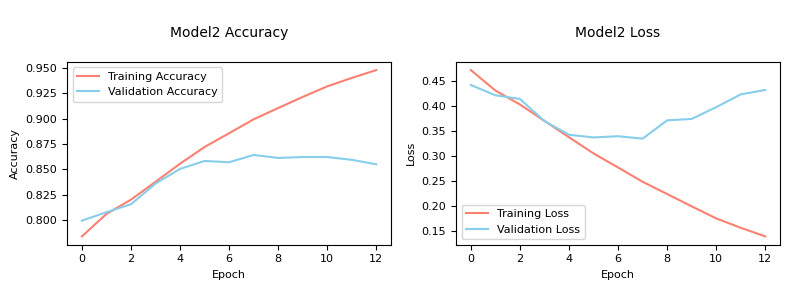

In [31]:
# Create ModelCheckpoint callback
checkpoint2 = ModelCheckpoint(
    filepath='model2_kaggle.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Create EarlyStopping callback
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# Start timer
start_time = time.time()

# Train the model2 and save the history
history2 = model2.fit(
    train_generator2,
    validation_data=valid_generator2,
    epochs=20,
    callbacks=[checkpoint2, early_stop]
)

# End timer
end_time = time.time()
print("-" * 120)

# Calculate total time
total_time = end_time - start_time
hours, remainder = divmod(total_time, 3600)
minutes, seconds = divmod(remainder, 60)

if hours > 0:
    print(f"Training completed in {int(hours)}h {int(minutes)}m {int(seconds)}s.")
elif minutes > 0:
    print(f"Training completed in {int(minutes)}m {int(seconds)}s.")
else:
    print(f"Training completed in {int(seconds)}s.")

# Best validation accuracy
print(f"Best Validation Accuracy: {max(history2.history['val_accuracy']):.4f}")

# Plot model2 accuracy and loss
fig, axes = plt.subplots(1, 2, figsize=(8, 3))

# Plot Accuracy
axes[0].plot(history2.history['accuracy'], label='Training Accuracy', color='salmon')
axes[0].plot(history2.history['val_accuracy'], label='Validation Accuracy', color='skyblue')
axes[0].set_title('\nModel2 Accuracy\n', fontsize=10)
axes[0].set_xlabel('Epoch', fontsize=8)
axes[0].set_ylabel('Accuracy', fontsize=8)
axes[0].tick_params(axis='both', which='major', labelsize=8)
axes[0].legend(fontsize=8)

# Plot Loss
axes[1].plot(history2.history['loss'], label='Training Loss', color='salmon')
axes[1].plot(history2.history['val_loss'], label='Validation Loss', color='skyblue')
axes[1].set_title('\nModel2 Loss\n', fontsize=10)
axes[1].set_xlabel('Epoch', fontsize=8)
axes[1].set_ylabel('Loss', fontsize=8)
axes[1].tick_params(axis='both', which='major', labelsize=8)
axes[1].legend(fontsize=8)

plt.tight_layout()
plt.show()

In [32]:
# Prepare test data (for grayscale images)
df_test = pd.DataFrame({'id':os.listdir(test_path)})

datagen = ImageDataGenerator(rescale=1/255)

test_generator2 = datagen.flow_from_dataframe(
    dataframe=df_test,
    directory=test_path,
    x_col="id",
    batch_size=64,
    seed=123,
    class_mode=None,
    target_size=(96, 96),
    color_mode="grayscale",   # Convert images to grayscale
    shuffle=False
)

Found 57458 validated image filenames.


In [33]:
# Predicting
predictions2 = model2.predict(test_generator2, verbose=1)

# Create submission dataframe
pred2 = np.transpose(predictions2)[0]

df_submission2 = pd.DataFrame()
df_submission2['id'] = df_test['id'].apply(lambda x: x.split('.')[0])
df_submission2['label'] = list(map(lambda x: 0 if x < 0.5 else 1, pred2))

df_submission2.head()

898/898 ━━━━━━━━━━━━━━━━━━━━ 66s 73ms/step


,id,label
0,a7ea26360815d8492433b14cd8318607bcf99d9e,0
1,59d21133c845dff1ebc7a0c7cf40c145ea9e9664,0
2,5fde41ce8c6048a5c2f38eca12d6528fa312cdbb,0
3,bd953a3b1db1f7041ee95ff482594c4f46c73ed0,1
4,523fc2efd7aba53e597ab0f69cc2cbded7a6ce62,0


In [34]:
df_submission2.to_csv('submission_grayscale.csv', index=False)

***
## **Step 4 Results and Analysis**

#### **4.1 Visualization Analysis**

- **Accuracy Plot**:
  
    - **Model 1 (RGB)**: The training and validation accuracy show steady improvement, with the validation accuracy peaking at **91.13%**. This indicates the model effectively learns from the data while maintaining good generalization.
      
    - **Model 2 (Grayscale)**: Although training accuracy reaches **95.13%**, validation accuracy stagnates and peaks at **86.41%**, showing the model struggles to generalize, likely due to limited input information and model complexity.
 
- **Loss Plot**:
 
    - **Model 1 (RGB)**: The training loss consistently decreases, while the validation loss stabilizes around epoch 7. A slight increase afterward suggests **mild overfitting** but not severe.

    - **Model 2 (Grayscale)**: The training loss decreases significantly, but validation loss starts increasing after epoch 8, indicating **stronger overfitting**. The gap between training and validation loss is larger than in Model 1.

![1](1.jpg)
![2](2.jpg)

***
#### **4.2 Key Observations**

- **Parameters**: **Model 2 (Grayscale Images)** has a significantly lower parameter count (**~613 K**) compared to Model 1 (**~1.7 M**).

- **Training Time**: Model 1 took significantly longer to train (**1h 2m 21s**) due to its larger parameter count and the need to process three image channels (RGB). Model 2 was faster (**43m 24s**) with fewer parameters and simpler input data (grayscale).

- **Validation Accuracy**: **Model 1 (Color Images)** achieved a higher validation accuracy (**91.13%**) compared to Model 2 (**86.41%**). The inclusion of RGB features provided richer input data, enabling better generalization on the validation set.
    
- **Kaggle Score**: While Model 1 outperformed Model 2 slightly (**0.8557** vs. **0.8487**), the difference is marginal, suggesting both models achieved reasonable performance.


![score](score.jpg)

In [3]:
# Define the data
model_num = ['Model1', 'Model2']
color_mode = ['Color Images', 'Grayscale Images']
parameters = ['~1.7 M (6.61 MB)', '~613 K (2.34 MB)']
train_time = ['1h 2m 21s', '43m 24s']
val_acc = [0.9113, 0.8641]
kaggle_score = [0.8557, 0.8487]

# Create DataFrame
comparison_df = pd.DataFrame({
    'Model': model_num,
    'For': color_mode,
    'Parameters': parameters,
    'Training time': train_time,
    'Validation accuracy': val_acc,
    'Kaggle score': kaggle_score
})

# Highlighting
def highlight_cells(val):
    highlight_values = ['~613 K (2.34 MB)', '43m 24s', 0.9113, 0.8557]
    return 'background-color: lightgreen' if val in highlight_values else ''

# Style the DataFrame
styled_df = comparison_df.style.applymap(highlight_cells).format({
    'Validation accuracy': '{:.4g}',
    'Kaggle score': '{:.4g}'
}).set_properties(**{
    'text-align': 'center'
}).set_table_styles([{
    'selector': 'th',
    'props': [('text-align', 'center')]
}])

styled_df

,Model,For,Parameters,Training time,Validation accuracy,Kaggle score
0,Model1,Color Images,~1.7 M (6.61 MB),1h 2m 21s,0.9113,0.8557
1,Model2,Grayscale Images,~613 K (2.34 MB),43m 24s,0.8641,0.8487


***
#### **4.3 Trade-Off of Two Models**

The comparison between Model 1 (Color Images) and Model 2 (Grayscale Images) reveals a clear trade-off between accuracy and efficiency. Model 1 achieved a validation accuracy of **91.13%**, outperforming Model 2's **86.41%** by **4.72%**, while the Kaggle scores differed by only **0.70%**. However, Model 1 has a significantly higher parameter count (**~1.7M** vs. **~613K**) and took approximately **30% longer** to train.

In real-world applications, this trade-off depends on the context. For example, in cancer diagnosis, accuracy is paramount, especially when false negatives could have severe consequences. In such cases, the richer feature set provided by color images justifies the added computational cost of Model 1.

Conversely, in resource-limited environments, such as rural clinics or mobile diagnostic devices, the faster training time and reduced computational requirements of Model 2 make it a more practical choice, even with slightly lower accuracy.

- **Balancing the Trade-Off**:

    - If **speed and efficiency** are priorities (e.g., screening large populations quickly), Model 2 is a better choice.

    - If **accuracy and minimizing errors** are critical (e.g., diagnosing cancer in a hospital setting), Model 1 should be prioritized despite its higher resource demands.

    - A hybrid approach could also be considered: using Model 2 for initial screening and Model 1 for more detailed, follow-up predictions.

***
## **Step 5 Conclusion**

In summary, model 1 excels in accuracy (91.13% validation accuracy) due to its richer RGB input and larger capacity, making it ideal for high-stakes tasks such as cancer diagnosis. Meanwhile, Model 2, with a lower validation accuracy (86.41%), demonstrates the advantages of lightweight architectures with faster predictions and reduced parameters, making it more suitable for resource-constrained settings.

What helped improve performance included richer input features (RGB images), regularization techniques like dropout, and early stopping. However, simpler architectures and grayscale inputs limited feature extraction capacity, reducing Model 2's accuracy.

For most people, while efforts focus on maximizing accuracy, efficiency considerations like parameters and training time are crucial in specific scenarios. Future efforts should focus on optimizing Model 2 to narrow the accuracy gap while maintaining its efficiency, ensuring broader applicability across diverse use cases.

**GitHub Repository Link**

https://github.com/d93xup60126/CNN_Cancer_Detection
***